<a href="https://colab.research.google.com/github/scubamut/CNTK/blob/master/Copy_of_MovingAverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://cssanalytics.wordpress.com/2019/11/26/adaptive-vix-moving-average/

https://www.youtube.com/watch?v=Voc78gnKX7s&feature=youtu.be

# Install Packages
_pyfolio_ is installed from _GitHub_ because the pip package contains a bug.

In [1]:
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-il7ldrpf
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-il7ldrpf
     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75764 sha256=7095cdd3a30433d7646641faf95d8618007670638f6d125152f7b4e281f7e664
  Stored in directory: /tmp/pip-ephem-wheel-cache-9o27wuk6/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39763 sha256=934fbbccee65d6a54c8edfa884a7ed3def73ef0f1bacb05ba5b150eee881618b
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


In [2]:
import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf
import scipy.stats as stats

from pandas_datareader import data

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Download the SPY (S&P 500)
Take care to save the series and load locally. Yahoo is likely to throttle or even ban the address if done multiple times.

The unadjusted close is used to compute the signal - 200-day simple moving average. The returns are computed using the adjusted closing prices.

In [3]:
spy = data.DataReader('SPY', data_source='yahoo', start='1990-01-01')
spy.columns = ['open', 'high', 'low', 'close', 'volume', 'adjusted']
close = spy['close']
rets = spy['adjusted'].pct_change()

In [4]:
def sma(prices, periods=200):
    ans = prices.rolling(window=periods, min_periods=periods).mean()
    ans.index.name = 'date'
    ans.columns = 'sma'
    return ans

In [5]:
ma = sma(close)
both = pd.concat([close, ma], axis=1)
both.columns = ['prices', 'ma']

# Compute the signal
Long (signal value of 1) when the close is above the moving average. Out of the market otherwise.

The signal is shifted by one to align with the daily returns. The assumption is that at the close of the day, we can compute the price and take a position.

Last call the _pyfolio_ module to create the strategy statistics off the strategy returns.

The strategy is computed only from 1996-01-01 to 2019-12-01 becase my goal was to reproduce [these results](https://cssanalytics.wordpress.com/2019/12/04/adaptive-vix-moving-average-with-ehlers-alpha-formula/).



---



Start date,1996-01-02
End date,2019-12-31
Total months,287
,Backtest
Annual return,6.929%
Cumulative returns,398.377%
Annual volatility,11.996%
Sharpe ratio,0.62
Calmar ratio,0.25
Stability,0.90
Max drawdown,-27.609%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.61,1999-07-16,2003-04-16,2006-04-20,1765
1,20.14,2007-07-19,2009-07-07,2009-12-22,634
2,16.99,2010-04-23,2010-09-14,2011-02-18,216
3,16.51,2011-04-29,2011-12-30,2013-02-08,466
4,16.21,1998-07-20,1998-10-27,1999-03-11,169


Stress Events,mean,min,max
Dotcom,-0.05%,-5.72%,4.67%
Lehman,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,-0.00%,-0.00%
Fukushima,0.14%,-1.85%,1.55%
US Housing,0.00%,-0.00%,-0.00%
EZB IR Event,-0.01%,-1.06%,1.52%
Aug07,-0.15%,-2.96%,1.39%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


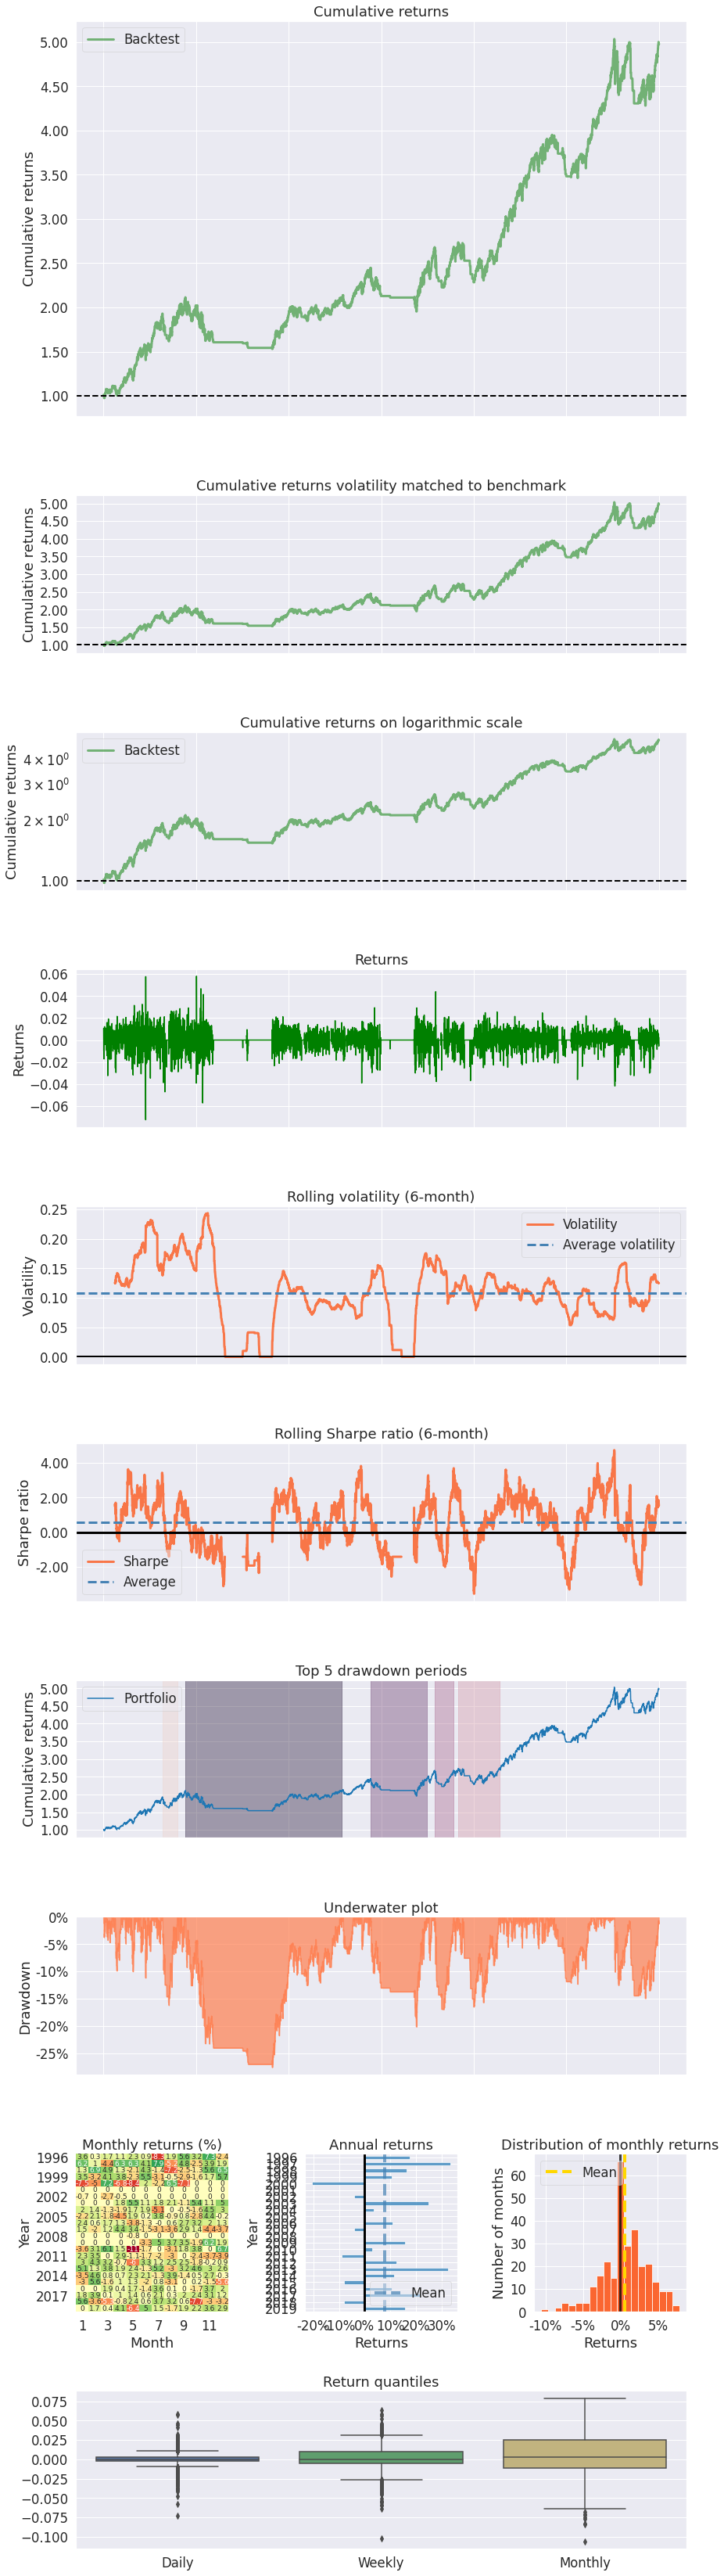

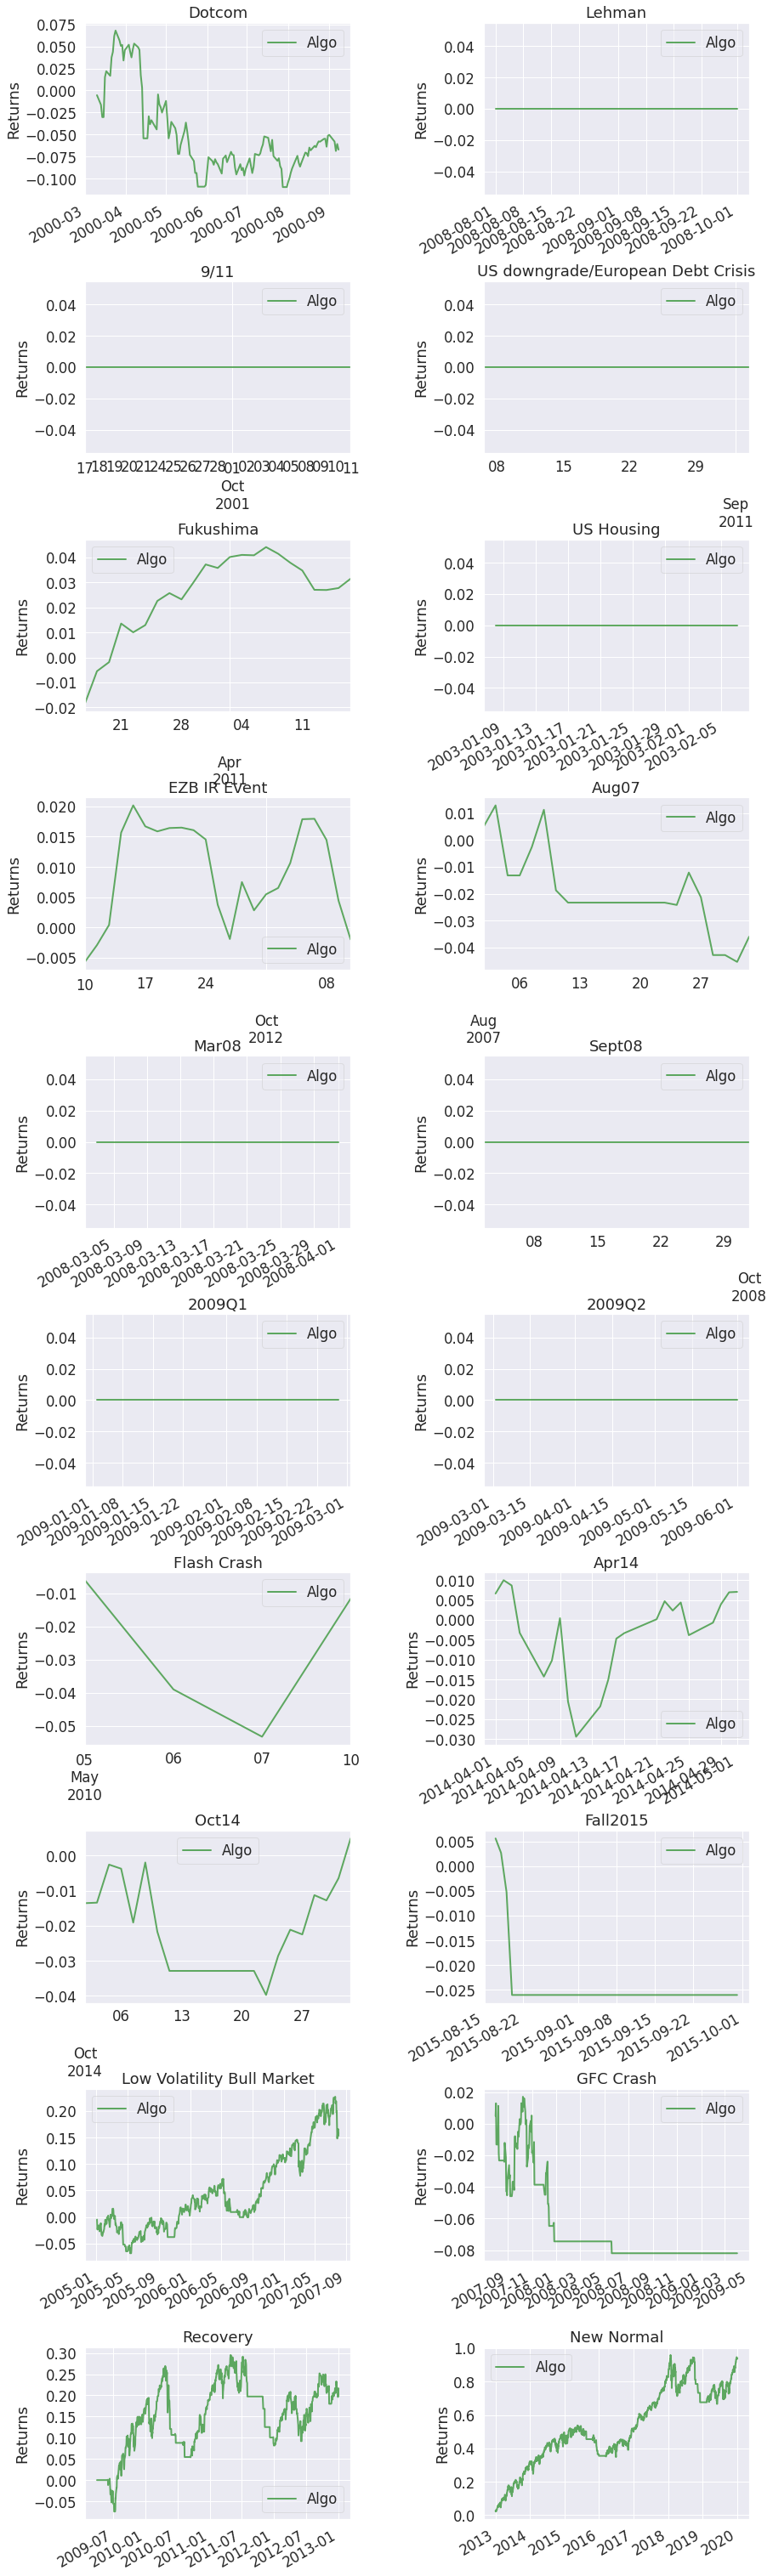

In [6]:
signal = pd.DataFrame(both.apply(lambda r: 0 if np.isnan(r['ma']) or r['ma'] > r['prices'] else 1, axis=1))
signal.columns = ['position']

df = pd.concat([rets, signal.shift()], axis=1)
df.columns = ['returns', 'position']
daily_rets = df.returns*df.position.fillna(0.0)
daily_rets.index.name = 'date'
daily_rets.columns = ['ma']

dr = daily_rets['1996-01-01':'2020-01-01']
sma_rets = dr
pf.create_full_tear_sheet(returns=dr)

# Computing the Adaptive Moving Average

In [ ]:
def rank_last(data):
    s = stats.rankdata(data, method='dense')
    return 1-s[len(s)-1]/max(s)

def std_zero(data):
    f = 1.0/(len(data)-1)
    return np.sqrt(f*np.power(data, 2).sum())

def ama(prices, rets=None, volatility_periods=25, ranking_periods=2000):
    if rets is None:
        rets = prices.pct_changes()
    vola = rets.rolling(window=volatility_periods, min_periods=volatility_periods).apply(std_zero, raw=True).fillna(0)
    ranked_vola = vola.expanding(min_periods=ranking_periods).apply(rank_last, raw=True)

    sc = 0.075
    fc = 0.75

    ans = prices.copy()

    alphas = prices.copy()

    prev = None
    for i in range(len(ranked_vola)):
        if np.isfinite(ranked_vola[i]):
            alpha = np.power(ranked_vola[i]*(fc - sc) + sc, 2)

            alphas[i] = alpha
            
            alpha = max(alpha, 0.01)
            alpha = min(alpha, 1.0)

            if prev is None:
                prev = prices[i-1]

            ans[i] = alpha*prices[i] + (1.0 - alpha)*prev

            prev = ans[i]
        else:
            ans[i] = np.nan
            alphas[i] = np.nan

    ans = pd.concat([ans, alphas], axis=1)
    ans.columns = ['ma', 'alpha']
    return ans

# Backtesting the Adaptive Moving Average Strategy

The SMA strategy returns are used as a benchmark.

Start date,1996-01-02
End date,2019-11-29
Total months,286
,Backtest
Annual return,9.706%
Cumulative returns,814.476%
Annual volatility,12.95%
Sharpe ratio,0.78
Calmar ratio,0.51
Stability,0.95
Max drawdown,-19.03%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.03,1998-07-20,1998-08-31,1998-11-23,91
1,17.31,2011-04-29,2011-08-08,2013-02-19,473
2,15.70,2010-04-23,2010-07-02,2011-01-14,191
3,12.78,1999-07-16,2000-02-25,2000-03-23,180
4,11.99,2007-10-09,2009-07-10,2009-08-03,475


Stress Events,mean,min,max
Dotcom,0.06%,-5.72%,4.67%
Lehman,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,-0.09%,-6.51%,4.65%
Fukushima,0.14%,-1.85%,1.55%
US Housing,0.00%,-0.00%,-0.00%
EZB IR Event,-0.01%,-1.06%,1.52%
Aug07,0.07%,-2.96%,1.96%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


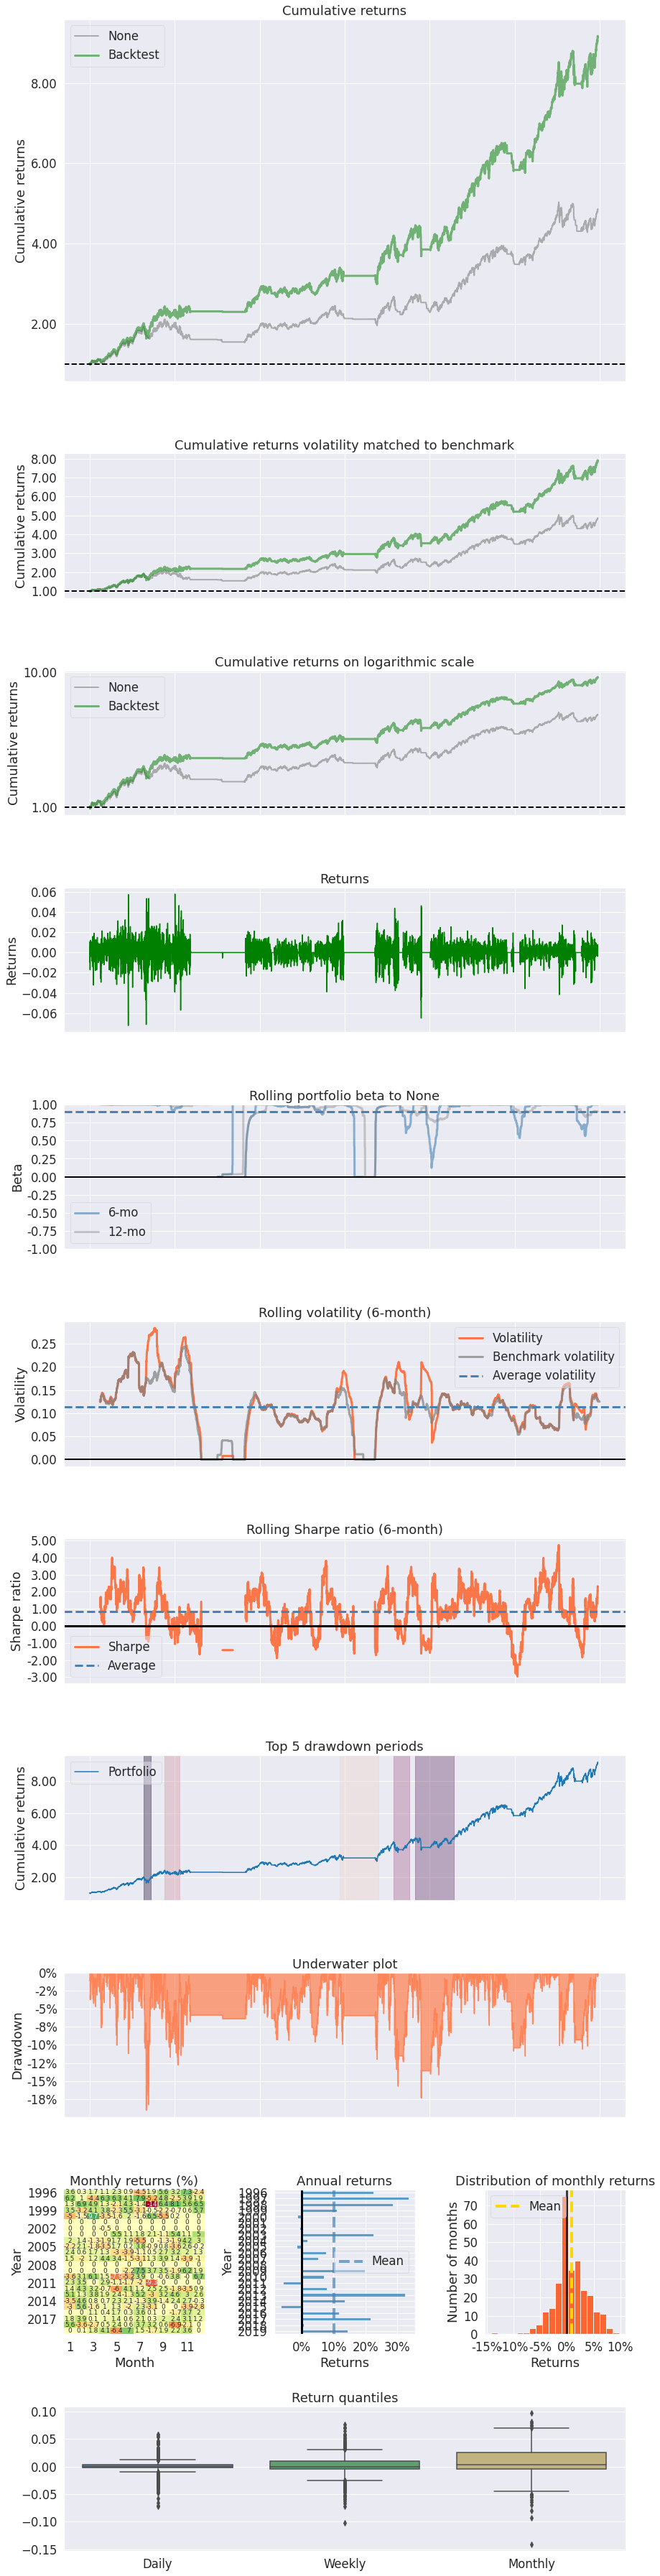

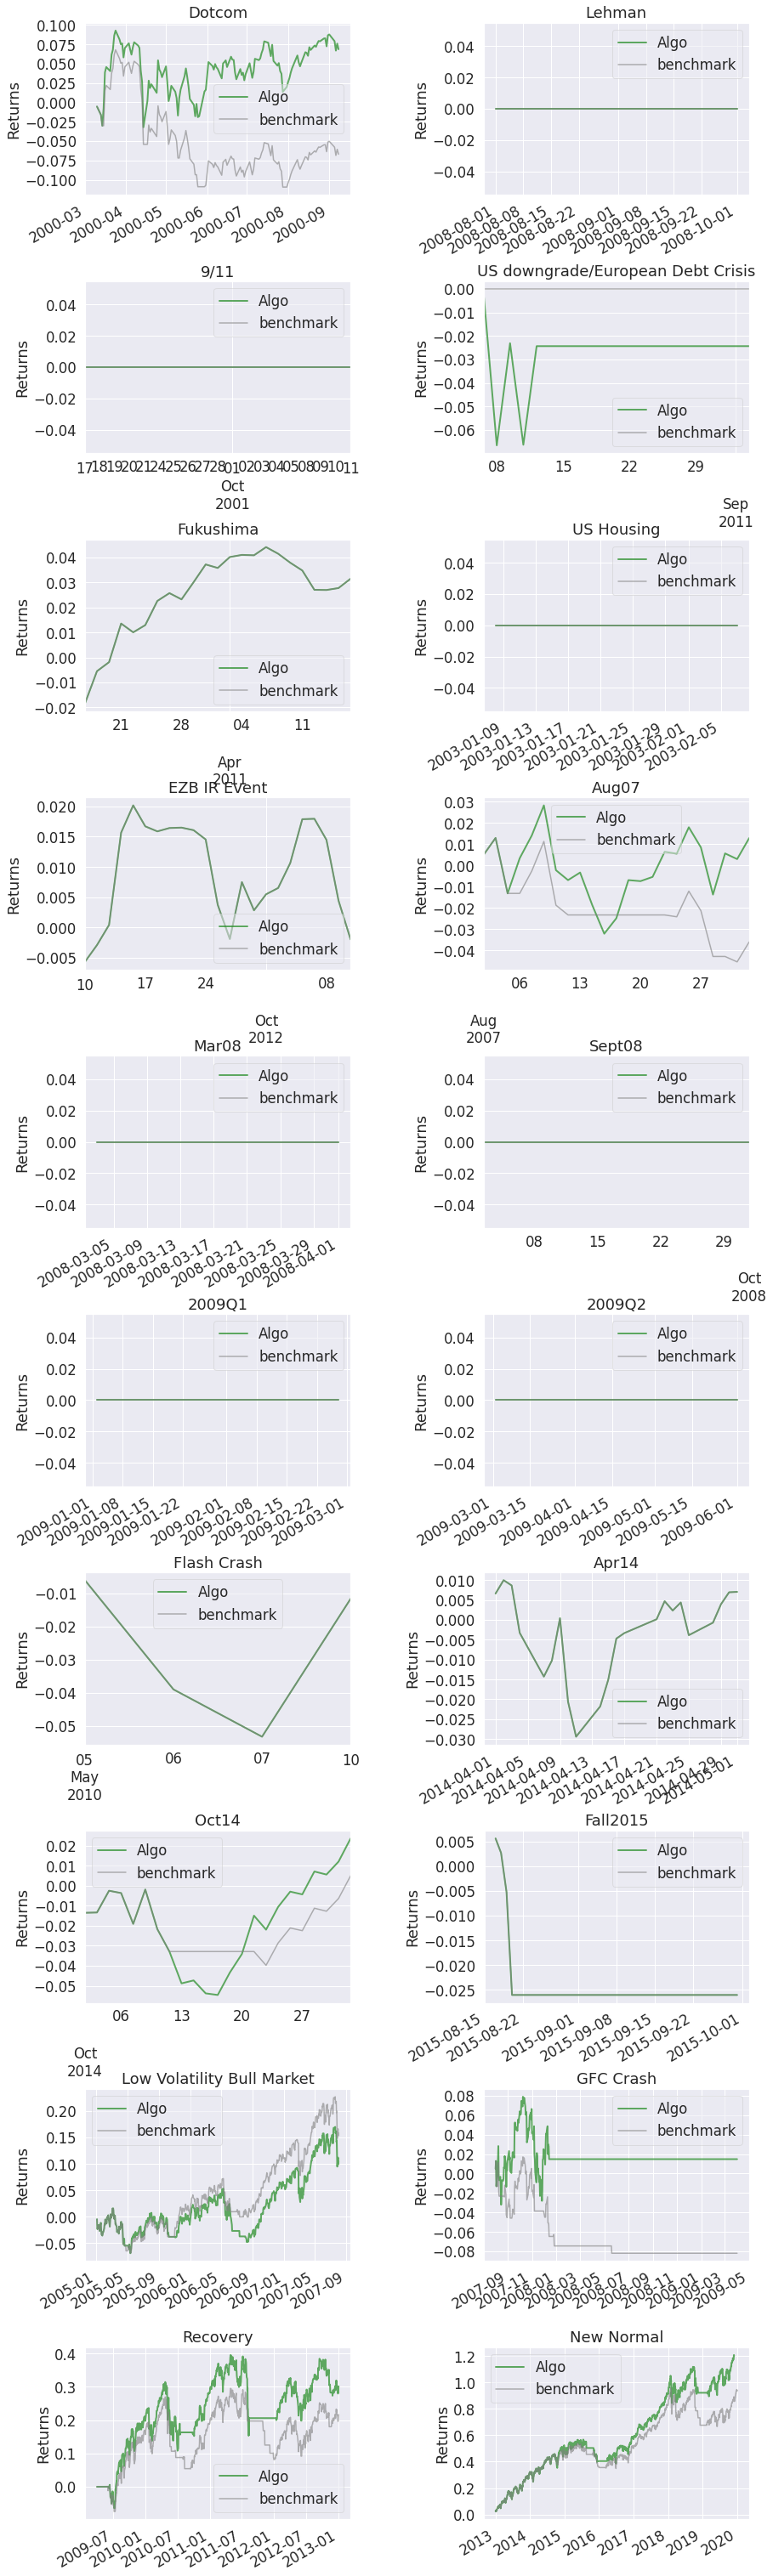

In [ ]:
ma = ama(close, rets, ranking_periods=1, volatility_periods=25)
ma200 = sma(close)
both = pd.concat([ma200, ma['ma']], axis=1)
both.columns = ['ma200', 'ma']

signal = pd.DataFrame(both.apply(lambda r: 0 if np.isnan(r['ma']) or np.isnan(r['ma200']) or r['ma200'] > r['ma'] else 1, axis=1))
signal.columns = ['position']

df = pd.concat([rets, signal.shift()], axis=1)
df.columns = ['returns', 'position']
daily_rets = df.returns*df.position.fillna(0.0)
daily_rets.index.name = 'date'
daily_rets.columns = ['ma']

dr = daily_rets['1996-01-01':'2019-12-01']
pf.create_full_tear_sheet(returns=dr, benchmark_rets=sma_rets)